In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

## SciGRID dataset

In [4]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


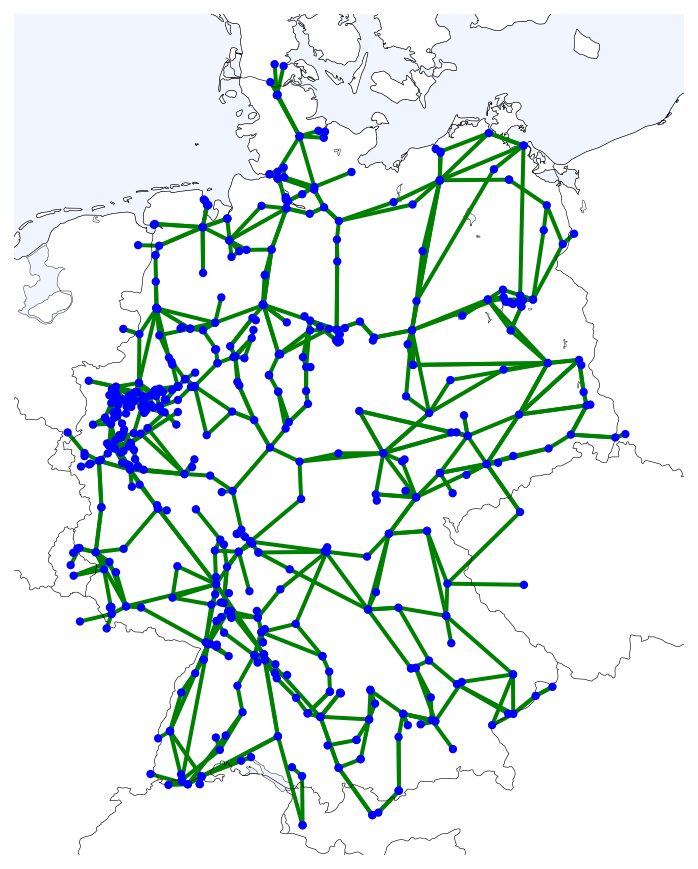

In [5]:
fig = plt.figure(figsize=(6,8))
import cartopy.crs as ccrs 
ax = fig.subplots(subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)})

import cartopy.feature

geomap = "10m"



sgn.network.plot(geomap=geomap, ax=ax)

ax.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.2, zorder=.5)
ax.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
ax.background_patch.set_facecolor("#f0f5ff")

## R `arima` results

In [6]:
armafits = ARMAfit_loader(sgn, 0)

In [7]:
def samplecovariance(x, y):
    return np.dot(x - np.mean(x), y - np.mean(y)) / (len(x) - 1)

In [8]:
dir(armafits)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'armafit_path',
 'compute_covariances',
 'isdaylighthourmonth',
 'jsoncontents',
 'load_month',
 'month_index',
 'monthlengths',
 'monthnames',
 'months',
 'monthstarts',
 'seriesofmonth',
 'sgn',
 'solar_generationmonth',
 'solar_monthseries',
 'solar_noised',
 't',
 'tmonth',
 'wind_generationmonth',
 'wind_monthseries',
 'wind_noised']

## Two random buses for a single carrier

In [9]:
A, B = sgn.random_bus_pair()

for name, index in [("A",A), ("B",B)]:
    if(index in sgn.offshorebuses):
        print("{0} is offshore".format(name))
    print("{0}={1} capacity: {2:.1f}MW solar, {3:.1f}MW wind".format(name, index, sgn.solar_capacity[index], sgn.wind_capacity[index]))

A=388 capacity: 1.7MW solar, 4.7MW wind
B=229 capacity: 298.3MW solar, 89.1MW wind


In [10]:
carrier = ["wind", "solar_ML_SANN"][1]

if carrier == "wind":
    monthseries = armafits.wind_monthseries
    generationmonth = armafits.wind_generationmonth
    capacity = sgn.wind_capacity
    noised = armafits.wind_noised
else:
    monthseries = armafits.solar_monthseries
    generationmonth = armafits.solar_generationmonth
    capacity = sgn.solar_capacity
    noised = armafits.solar_noised

In [11]:
resA = monthseries[A]["residuals"]
resB = monthseries[B]["residuals"]

genA = generationmonth[A,:]
genB = generationmonth[B,:]
capA = capacity[A]
capB = capacity[B]

assert(monthseries[A]["bus"][0] == A + 1)
assert(monthseries[B]["bus"][0] == B + 1)

In [12]:
pd.Series(genB).describe()

count    744.000000
mean      32.619693
std       68.626148
min        0.000000
25%        0.000000
50%        0.000000
75%        7.839145
max      267.149345
dtype: float64

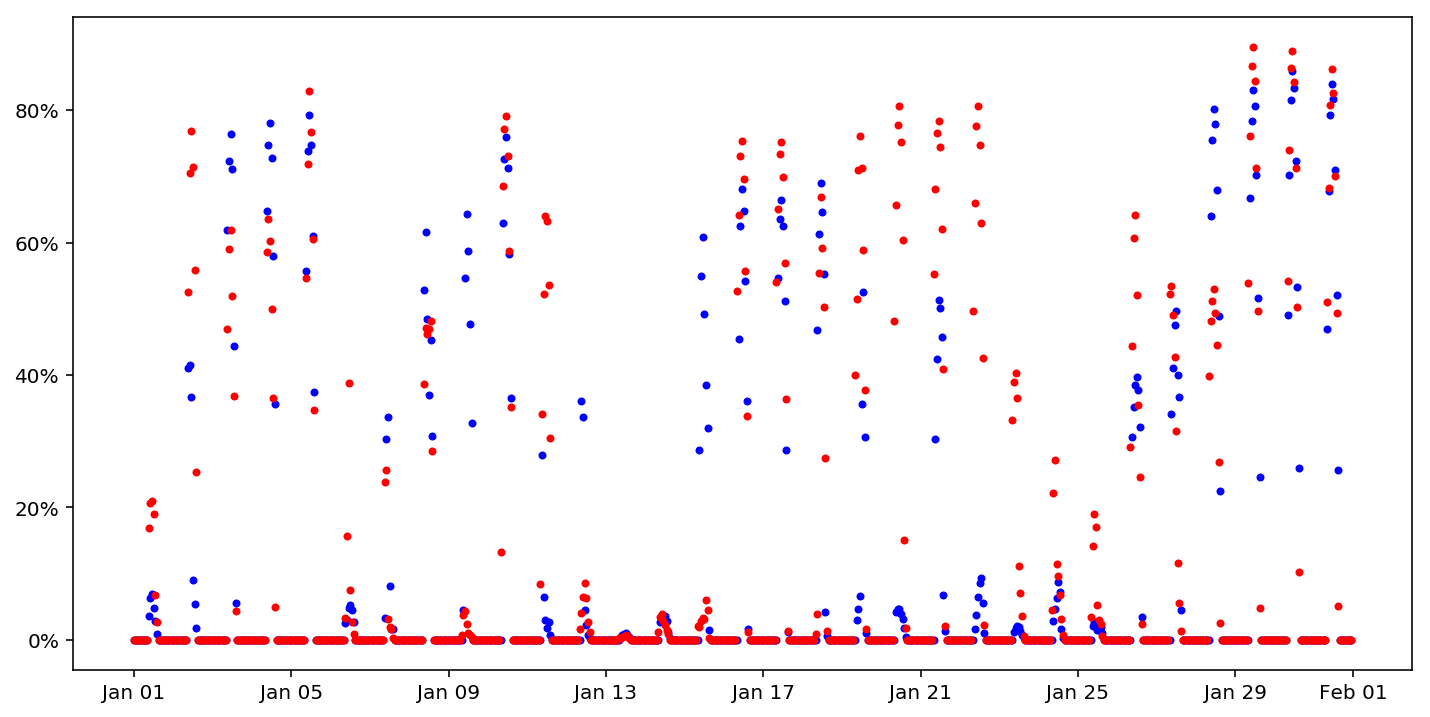

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(armafits.tmonth, genA / capA, ".", c="b")
ax.plot(armafits.tmonth, genB / capB, ".", c="r")
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %d"))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(True))
#https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

Text(0.9, 0.1, 'cov = 18.5')

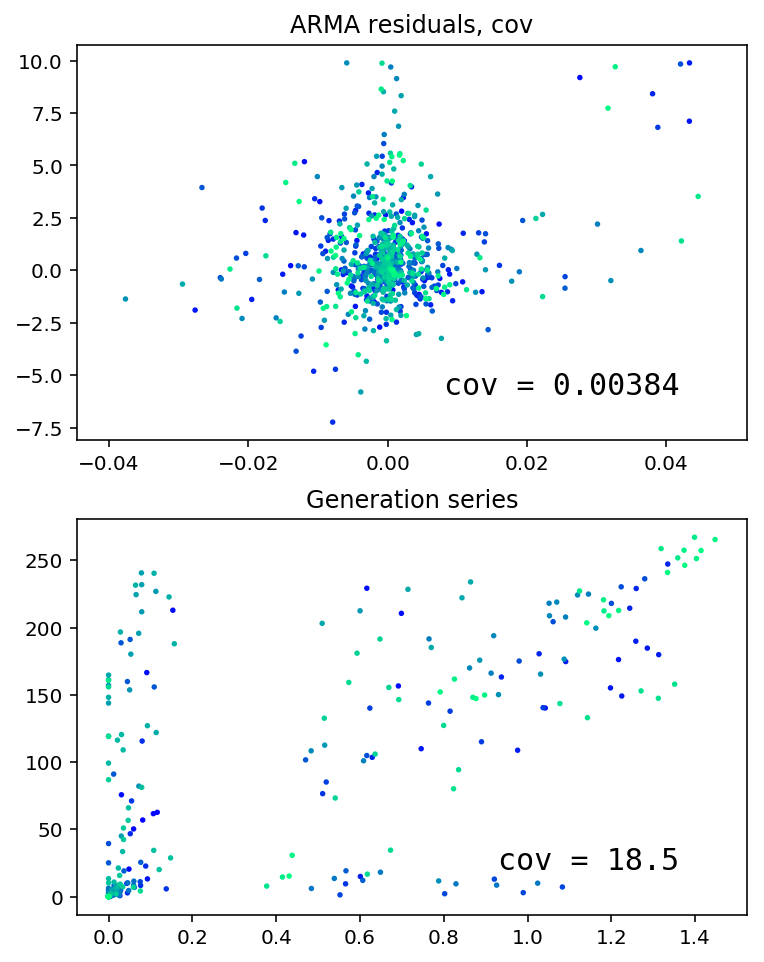

In [14]:
font = matplotlib.font_manager.FontProperties(family="monospace")

#plt.rc('text', usetex=False)

fig, ax = plt.subplots(2,1, figsize=(6,8))
ax[0].scatter(resA, resB, s=3, c=np.linspace(0, 1, num=len(resA)), cmap="winter")
ax[1].scatter(genA, genB, s=3, c=np.linspace(0, 1, num=len(resA)), cmap="winter")

ax[0].set_title("ARMA residuals, cov")
ax[1].set_title("Generation series")

rescovAB = samplecovariance(resA, resB)
gencovAB = samplecovariance(genA, genB)
ax[0].text(0.9, 0.1, "cov = {:.3g}".format(rescovAB), horizontalalignment="right", verticalalignment="bottom", transform=ax[0].transAxes, fontproperties=font, fontsize=15)
ax[1].text(0.9, 0.1, "cov = {:.3g}".format(gencovAB), horizontalalignment="right", verticalalignment="bottom", transform=ax[1].transAxes, fontproperties=font, fontsize=15)

# Covariance matrices, both carriers (solar+wind)

In [15]:
armafits.compute_covariances()

Let's pick 10000 random bus pairs, and examine their covariances.

In [16]:
num = 10000
np.random.seed(12345)
randompairs = [sgn.random_bus_pair() for _ in range(num)]


solar_gencovs = np.array([armafits.solar_gencovnorm[i,j] for i,j in randompairs])
solar_rescovs = np.array([armafits.solar_rescovnorm[i,j] for i,j in randompairs])
#solar_rescovsshuffled = np.array([armafits.solar_resshuffledcovnorm[i,j] for i,j in randompairs])
solar_gendaylightcovs = np.array([armafits.solar_gendaylightcovnorm[i,j] for i,j in randompairs])
solar_resdaylightcovs = np.array([armafits.solar_resdaylightcovnorm[i,j] for i,j in randompairs])

solar_gendaylightautocovs = np.array([armafits.solar_gendaylightcovnorm[i,i] for i,j in randompairs])
solar_resdaylightautocovs = np.array([armafits.solar_resdaylightcovnorm[i,i] for i,j in randompairs])

solar_diffcovs = np.array([armafits.solar_diffcovnorm[i,i] for i,j in randompairs])
solar_diffdaylightcovs = np.array([armafits.solar_diffdaylightcovnorm[i,i] for i,j in randompairs])

wind_gencovs = np.array([armafits.wind_gencovnorm[i,j] for i,j in randompairs])
wind_rescovs = np.array([armafits.wind_rescovnorm[i,j] for i,j in randompairs])
#wind_rescovsshuffled = np.array([armafits.wind_resshuffledcovnorm[i,j] for i,j in randompairs])

wind_diffcovs = np.array([armafits.wind_diffcovnorm[i,j] for i,j in randompairs])

solar_isnoisedpair = [i in armafits.solar_noised or j in armafits.solar_noised for i,j in randompairs]
wind_isnoisedpair = [i in armafits.wind_noised or j in armafits.wind_noised for i,j in randompairs]

In [110]:
def draw_axes(ax):
    ax.axhline(0.0, c="#999999", linewidth=1)
    ax.axvline(0.0, c="#999999", linewidth=1)

def draw_unit_slope(ax):
    ax.autoscale(False)
    ax.plot([-1,1],[-1,1],c="0", label="unit slope")

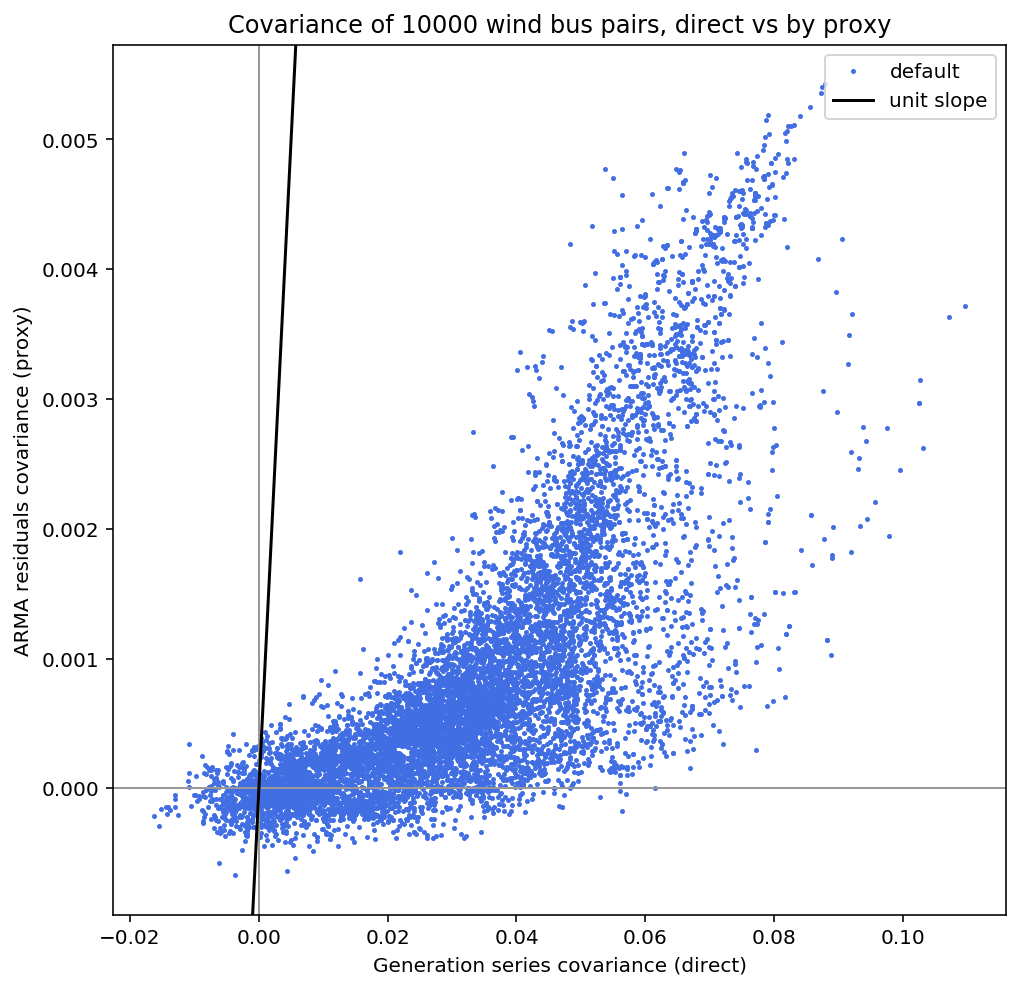

In [121]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(wind_gencovs, wind_diffcovs, ".", markersize = 3, c=src.globals.wind_color, label="default")
#ax.plot(wind_gencovs[wind_isnoisedpair], wind_rescovs[wind_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_gencovs, solar_rescovsshuffled, ".", markersize=1, c="r", label="shuffled")

draw_axes(ax)

#ax.set_xlim(0,0.05)
#ax.set_ylim(0,0.0002)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))

draw_unit_slope(ax)

ax.set_title("Covariance of {0} wind bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

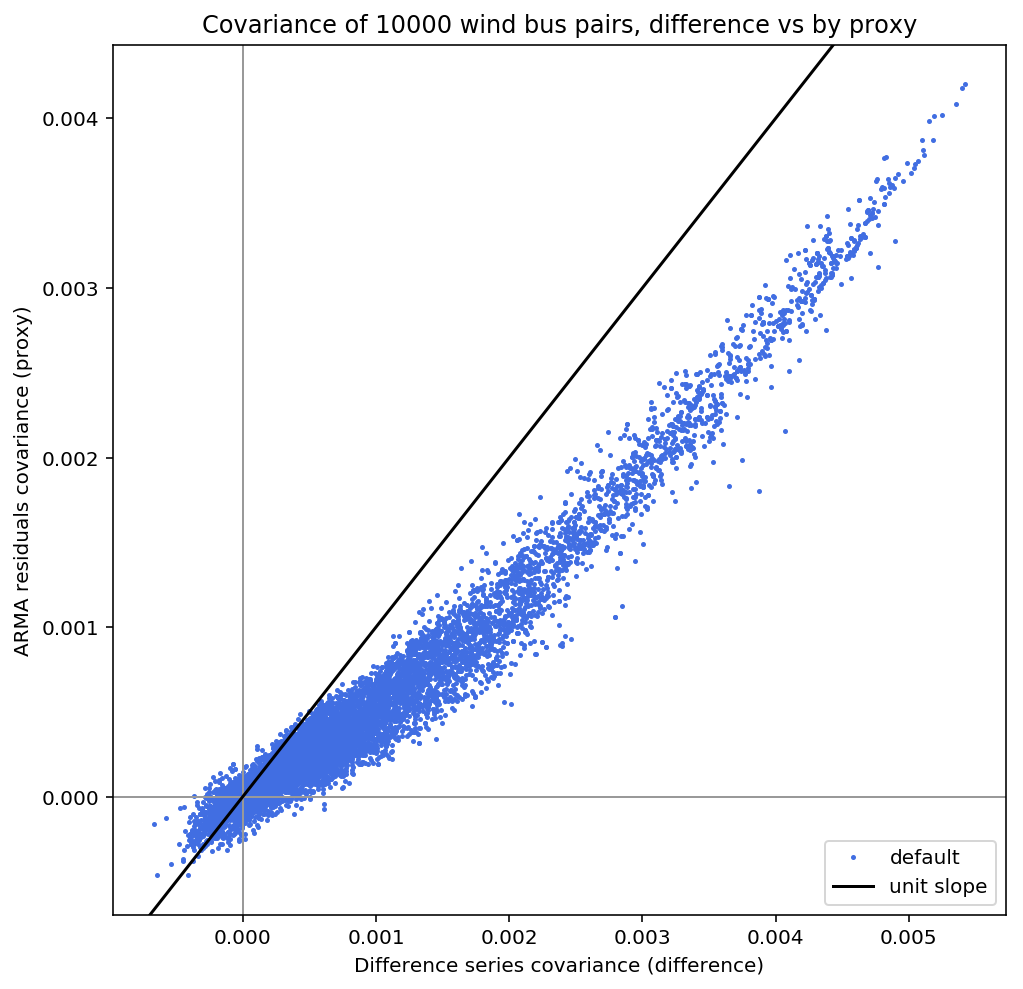

In [112]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(wind_diffcovs, wind_rescovs, ".", markersize = 3, c=src.globals.wind_color, label="default")
#ax.plot(wind_gencovs[wind_isnoisedpair], wind_rescovs[wind_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_gencovs, solar_rescovsshuffled, ".", markersize=1, c="r", label="shuffled")

draw_axes(ax)

#ax.set_xlim(0,0.05)
#ax.set_ylim(0,0.0002)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))

draw_unit_slope(ax)

ax.set_title("Covariance of {0} wind bus pairs, difference vs by proxy".format(num))
ax.set_xlabel("Difference series covariance (difference)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

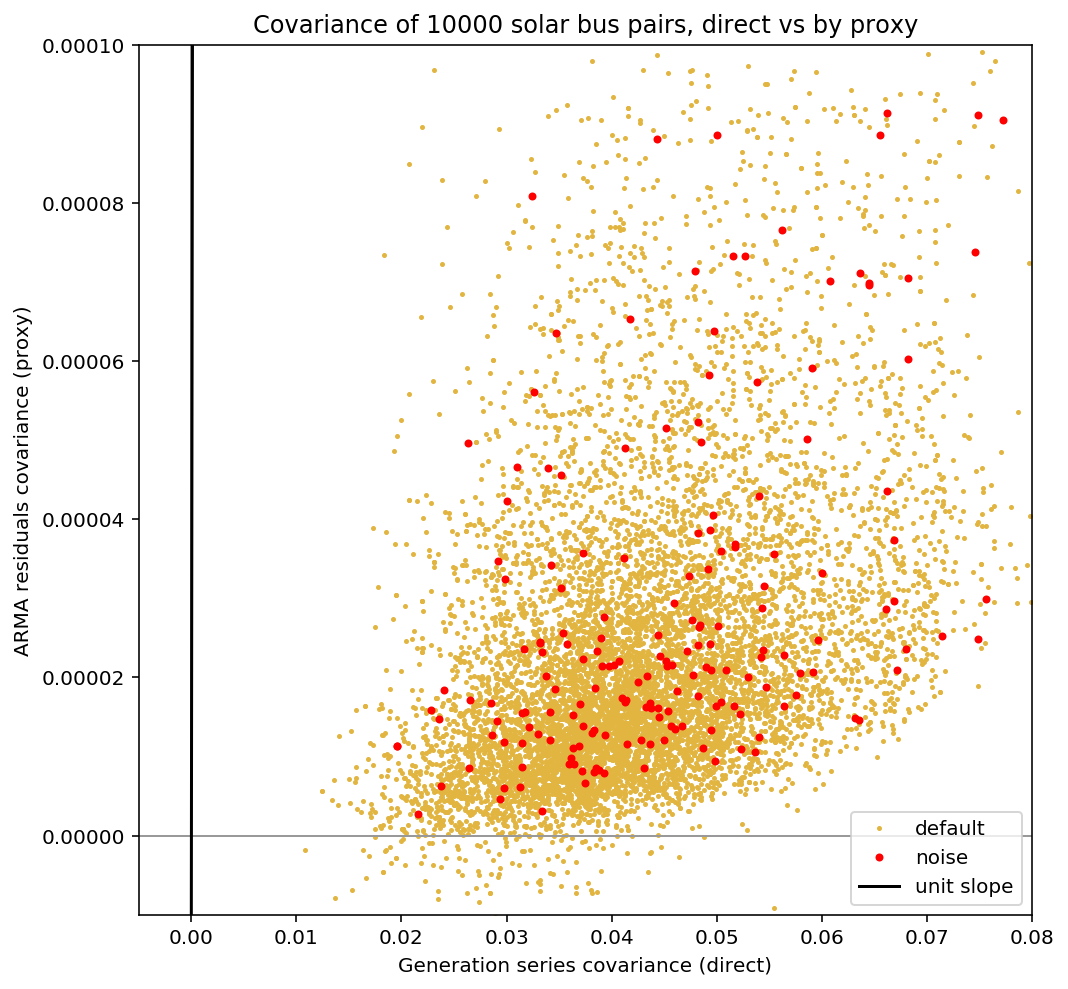

In [114]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(solar_gendaylightcovs, solar_resdaylightcovs, ".", markersize = 3, c=src.globals.solar_color, label="default")
ax.plot(solar_gendaylightcovs[solar_isnoisedpair], solar_resdaylightcovs[solar_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_gencovs, solar_rescovsshuffled, ".", markersize=1, c="r", label="shuffled")

draw_axes(ax)

ax.set_xlim(-0.005,0.08)
ax.set_ylim(-0.00001,0.0001)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))

draw_unit_slope(ax)

ax.set_title("Covariance of {0} solar bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

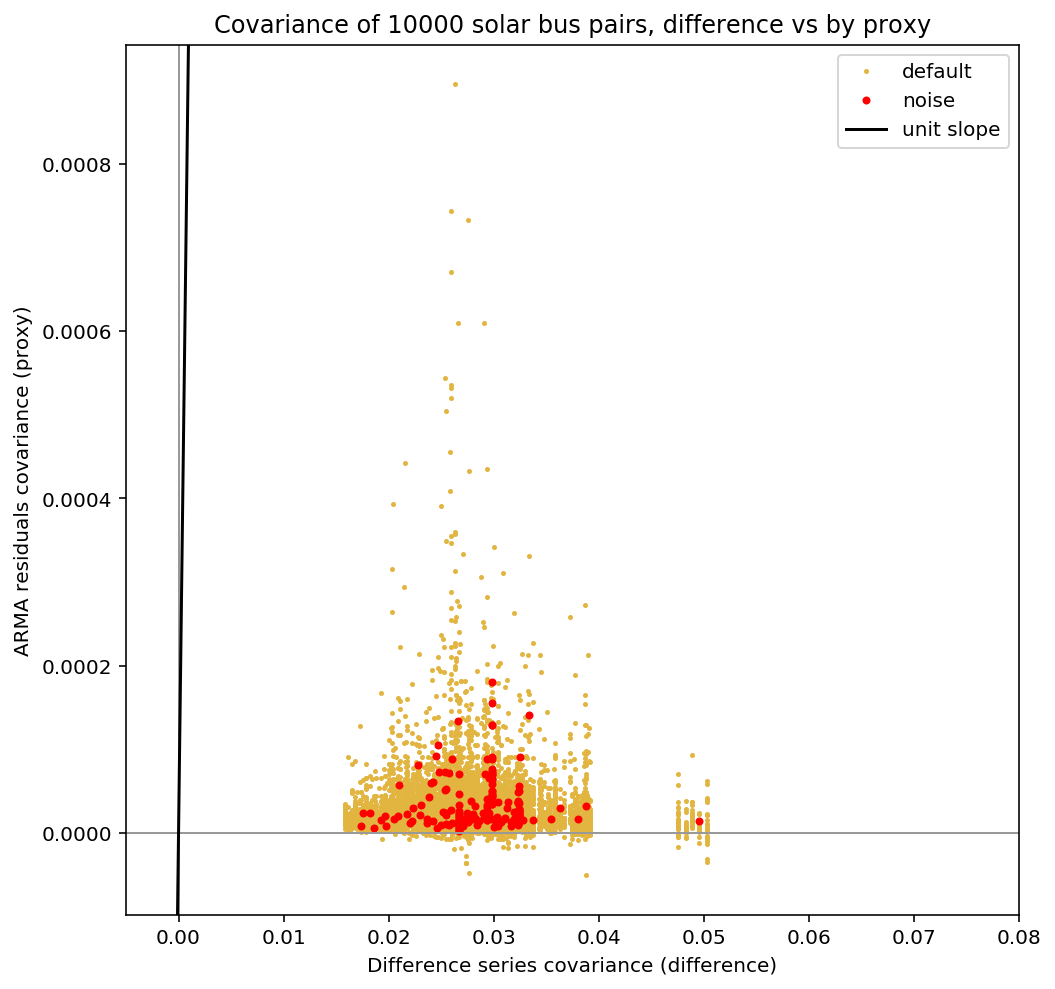

In [115]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(solar_diffdaylightcovs, solar_resdaylightcovs, ".", markersize = 3, c=src.globals.solar_color, label="default")
ax.plot(solar_diffdaylightcovs[solar_isnoisedpair], solar_resdaylightcovs[solar_isnoisedpair], ".", markersize = 6, c="r", label="noise")
#ax.plot(solar_gencovs, solar_rescovsshuffled, ".", markersize=1, c="r", label="shuffled")

ax.axhline(0.0, c="#999999", linewidth=1)
ax.axvline(0.0, c="#999999", linewidth=1)

ax.set_xlim(-0.005,0.08)
#ax.set_ylim(-0.00001,0.0001)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))

draw_unit_slope(ax)

ax.set_title("Covariance of {0} solar bus pairs, difference vs by proxy".format(num))
ax.set_xlabel("Difference series covariance (difference)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

(0, 0.001)

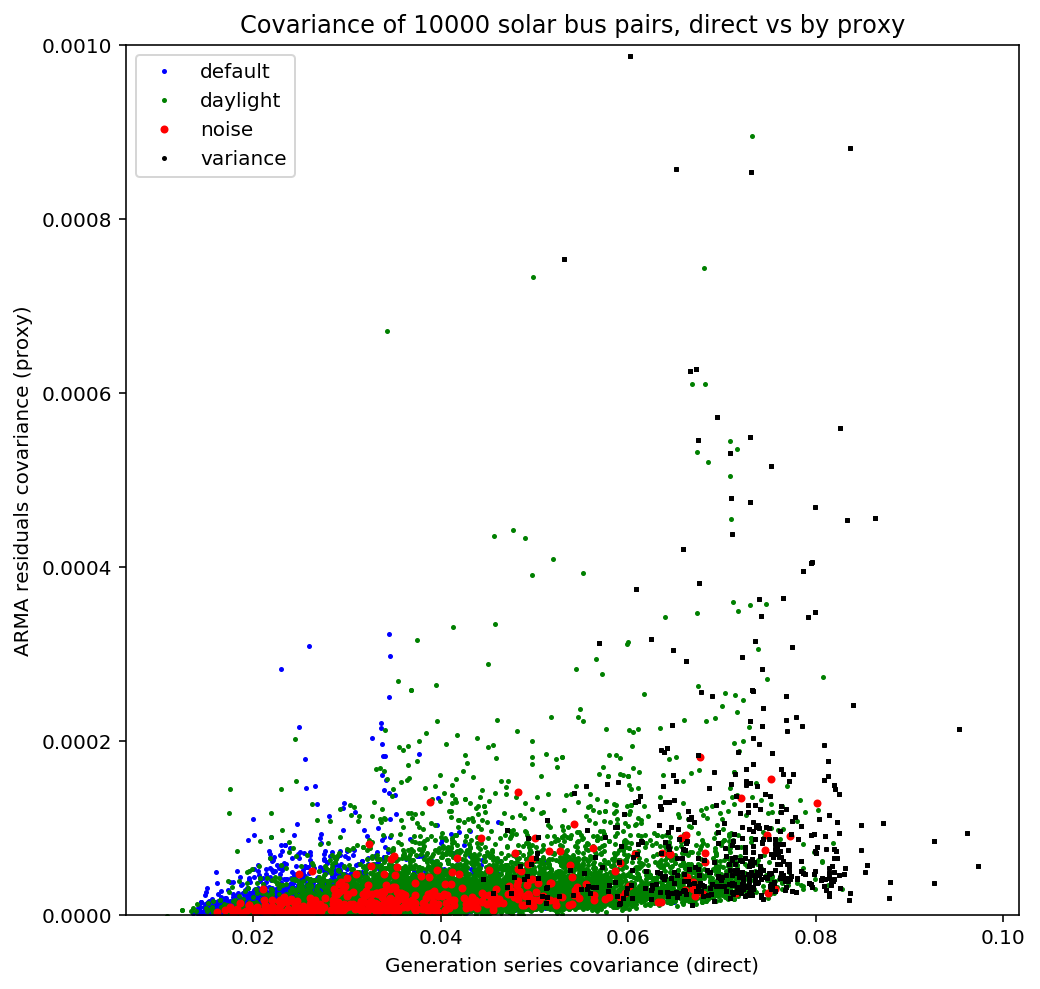

In [61]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(solar_gencovs, solar_rescovs, ".", markersize = 3, c="b", label="default")
ax.plot(solar_gendaylightcovs, solar_resdaylightcovs, ".", markersize = 3, c="g", label="daylight")
ax.plot(solar_gencovs[solar_isnoisedpair], solar_rescovs[solar_isnoisedpair], ".", markersize = 6, c="r", label="noise")
ax.plot(solar_gendaylightcovs[solar_isnoisedpair], solar_resdaylightcovs[solar_isnoisedpair], ".", markersize = 6, c="r")
#ax.plot(solar_gendaylightautocovs, solar_resdaylightautocovs, ".", markersize = 3, c="0", label="variance")
#ax.plot(solar_gencovs, solar_rescovsshuffled, ".", markersize=1, c="r", label="shuffled")


ax.set_title("Covariance of {0} solar bus pairs, direct vs by proxy".format(num))
ax.set_xlabel("Generation series covariance (direct)")
ax.set_ylabel("ARMA residuals covariance (proxy)")
ax.legend()

#ax.set_xlim(0,0.08)
ax.set_ylim(0,0.001)


#polyfit = np.polynomial.polynomial.Polynomial.fit(*zip(*solar_covs), deg=2)
#ax.plot(*polyfit.linspace(200))


# Relation: distance - correlation

In [62]:
dists = list(itertools.starmap(sgn.node_distance, randompairs))

Text(0, 0.5, 'Distance (km)')

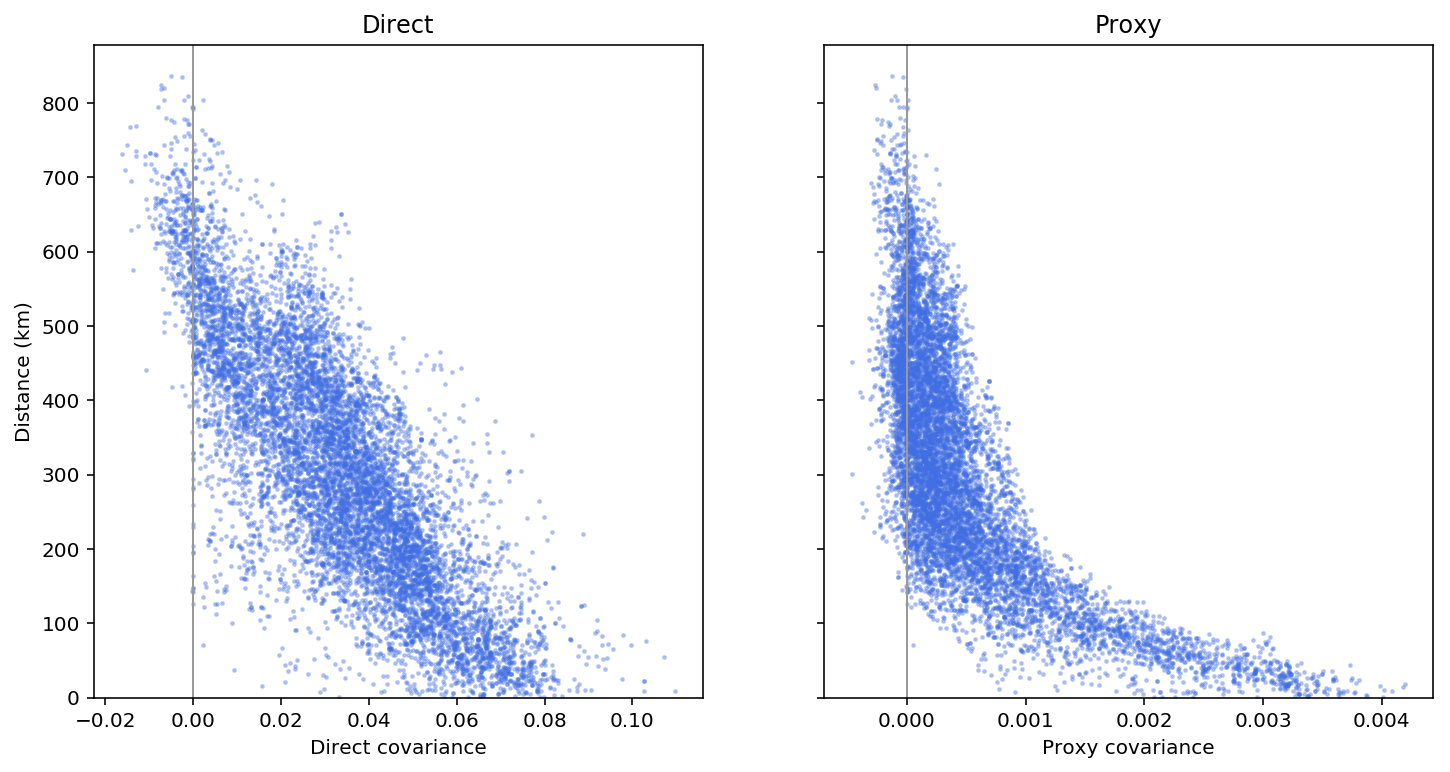

In [99]:
def set_ymin_to_zero(ax):
    a,b = ax.get_ylim()
    ax.set_ylim(0.0,b)

fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

plotargs = {"markersize":3, "c":src.globals.wind_color, "alpha":0.3}

ax[0].plot(wind_gencovs, dists, ".", **plotargs)
#ax[0,0].set_xlim(0.01, 0.09)
ax[1].plot(wind_rescovs, dists, ".", **plotargs)
#ax[0,1].set_xlim(-0.00001, 0.00005)

ax[0].axvline(0.0, c="#999999", linewidth=1)
ax[1].axvline(0.0, c="#999999", linewidth=1)

set_ymin_to_zero(ax[0])
set_ymin_to_zero(ax[1])

ax[0].set_title("Direct")
ax[1].set_title("Proxy")

ax[0].set_xlabel("Direct covariance")
ax[1].set_xlabel("Proxy covariance")
ax[0].set_ylabel("Distance (km)")

Text(0.5, 0, 'Covariance')

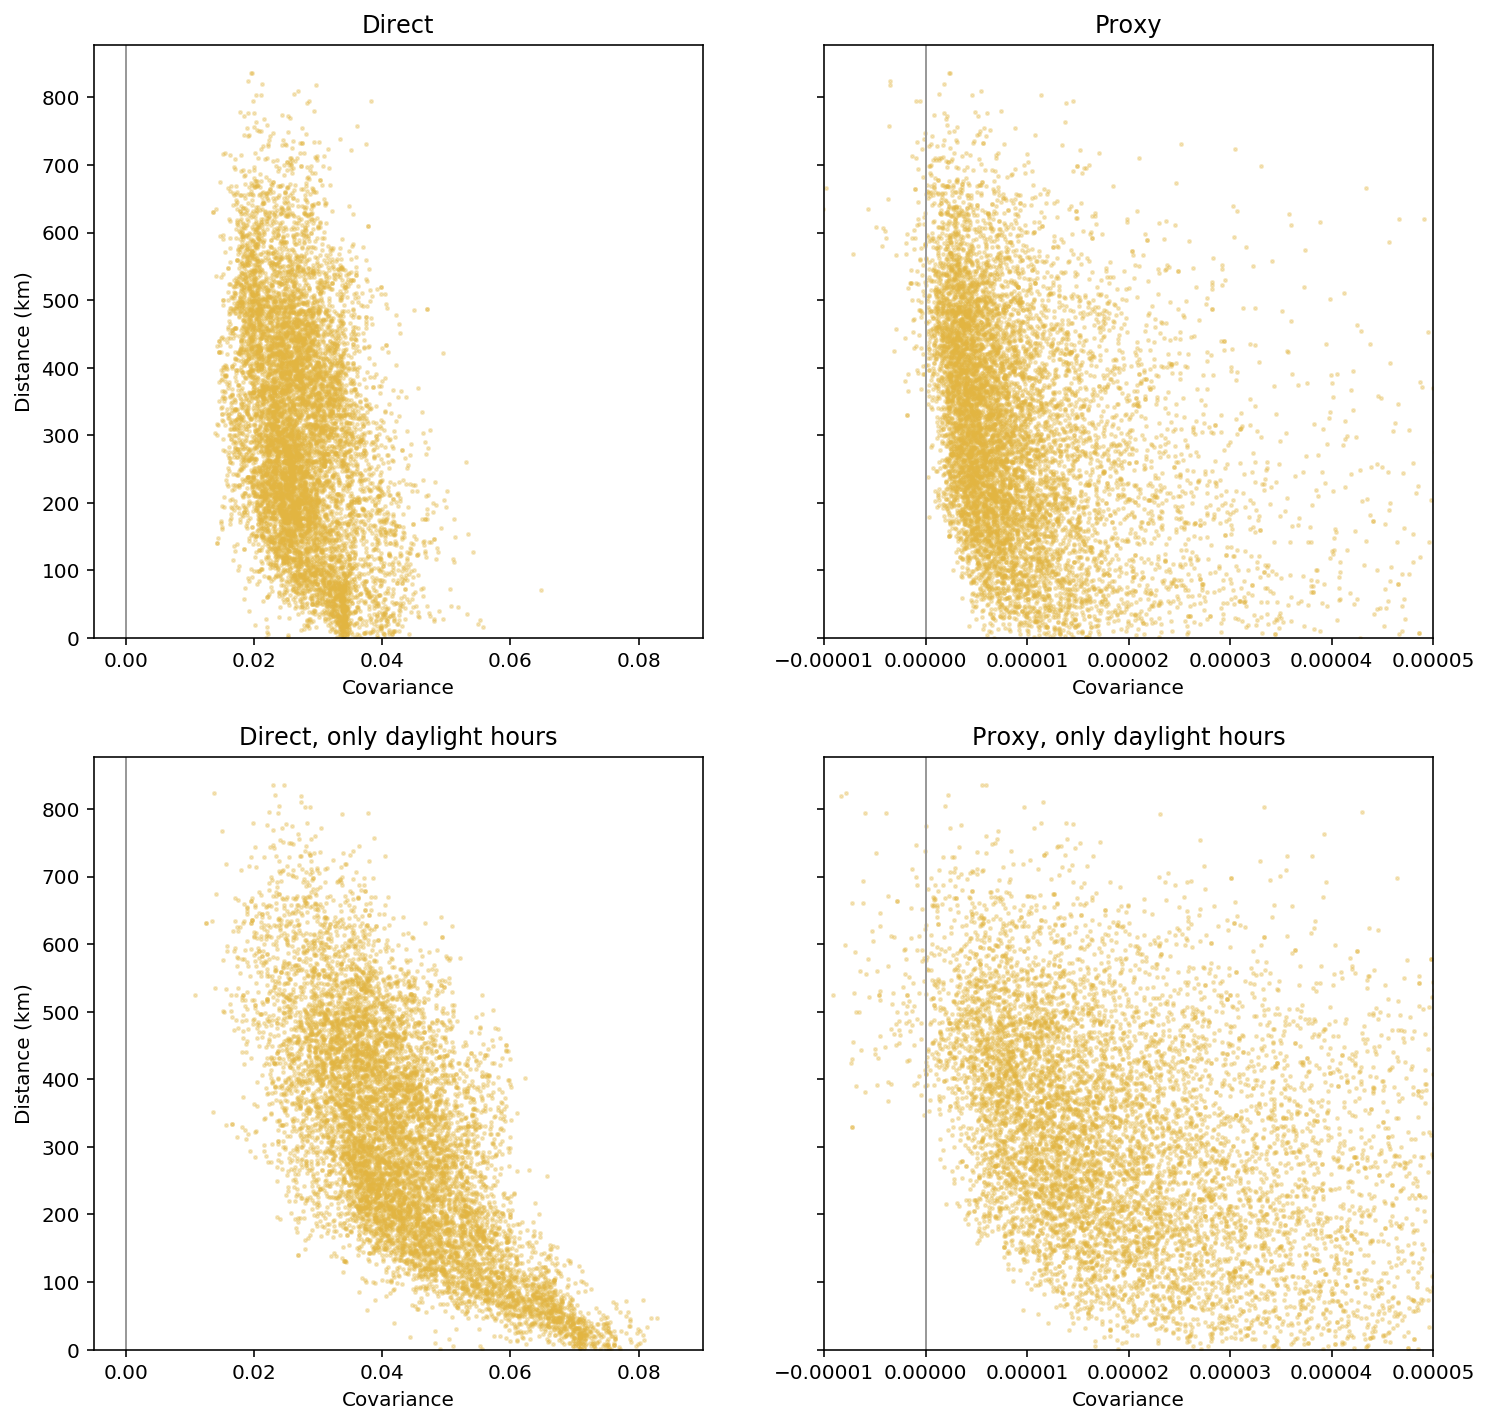

In [64]:
fig, ax = plt.subplots(2,2,figsize=(12,12),sharey=True)

plotargs = {"markersize":3, "c":src.global.solar_color, "alpha":0.3}

ax[0,0].plot(solar_gencovs, dists, ".", **plotargs)
ax[0,0].set_xlim(-0.005, 0.09)
ax[0,1].plot(solar_rescovs, dists, ".", **plotargs)
ax[0,1].set_xlim(-0.00001, 0.00005)
ax[1,0].plot(solar_gendaylightcovs, dists, ".", **plotargs)
ax[1,0].set_xlim(-0.005, 0.09)
ax[1,1].plot(solar_resdaylightcovs, dists, ".", **plotargs)
ax[1,1].set_xlim(-0.00001, 0.00005)

ax[0,0].axvline(0.0, c="#999999", linewidth=1)
ax[0,1].axvline(0.0, c="#999999", linewidth=1)
ax[1,0].axvline(0.0, c="#999999", linewidth=1)
ax[1,1].axvline(0.0, c="#999999", linewidth=1)

set_ymin_to_zero(ax[0,0])
set_ymin_to_zero(ax[1,0])

ax[0,0].set_title("Direct")
ax[0,1].set_title("Proxy")
ax[1,0].set_title("Direct, only daylight hours")
ax[1,1].set_title("Proxy, only daylight hours")

ax[0,0].set_ylabel("Distance (km)")
ax[1,0].set_ylabel("Distance (km)")

ax[0,0].set_xlabel("Covariance")
ax[0,1].set_xlabel("Covariance")
ax[1,0].set_xlabel("Covariance")
ax[1,1].set_xlabel("Covariance")